In [1]:
import os
 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 包的导入

In [2]:
import pandas as pd
import numpy as np
import cv2
from easydict import EasyDict
import yaml
import pdb

import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import Dataset, DataLoader, Subset # Subset可以从大训练集中抽样出小的验证集
from torch.nn import CrossEntropyLoss, NLLLoss #损失函数定义
# CrossEntropyLoss 自动添加softmax

import albumentations as A
from albumentations.pytorch import ToTensorV2 #转化为pytorch格式

import timm

import matplotlib.pyplot as plt
%matplotlib inline

## 包的下载

In [3]:
#包的导入
#pip install opencv-python
#python.exe -m pip install --upgrade pip
#pip install easydict
# pip install --user albumentations
#pip install timm

## 数据集导入与加载

In [4]:
# 当前文件目录
# print(os.path.abspath('.'))

In [5]:
train=pd.read_csv("./digit-recognizer/train.csv")
test = pd.read_csv("./digit-recognizer/test.csv")
submission =  pd.read_csv("./digit-recognizer/sample_submission.csv")

### 数据集预览

In [6]:
# 训练集数据预览
train.head(2) 

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


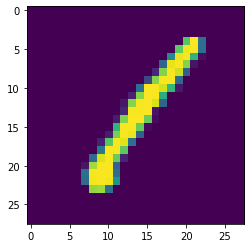

In [7]:
# 训练集第一个数据图像预览
    # iloc [行，列]
plt.imshow(train.iloc[0,1:].values.reshape(28,28)) 

In [8]:
test.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [10]:
# 数据集划分成image 与label
train_images = train.iloc[:,1:].values.reshape(-1,28,28)
train_labels = train.iloc[:,0].values

test_images = test.iloc[:,0:].values.reshape(-1,28,28)

In [11]:
train_images.shape

(42000, 28, 28)

In [12]:
test_images.shape

(28000, 28, 28)

In [13]:
train_labels.shape

(42000,)

In [14]:
# 查看训练集的标签
set(train_labels)  # set() 不包含重复元素遍历

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [15]:
train_images.mean()/255

0.13101533792088266

In [16]:
train_images.std()/255  # 标准差

0.3085401559245608

In [17]:
train_images.max()

255

## Image Augmentation

1. 图片增强
2. 图片尺寸
3. 标准化
4. 匹配到模型的input format;

In [18]:
# 图片增强
def get_transform(image_size,train=True):
    if train:
        return A.Compose([
#             A.RandomCrop(width=22,height=22), # 随机裁剪
            A.HorizontalFlip(p=0.5), # 水平翻转
            A.VerticalFlip(p=0.5), # 垂直翻转
            A.RandomBrightnessContrast(p=0.2), 
            A.Resize(*image_size,interpolation=cv2.INTER_LANCZOS4),# 数据变换尺寸
            A.Normalize(0.1310,0.30854), #数据标准化
            ToTensorV2(),# 将数据变成pytorch可用格式---增加通道
        ])
    else:
         return A.Compose([
            A.Resize(*image_size,interpolation=cv2.INTER_LANCZOS4),# 数据变换尺寸
            A.Normalize(0.1310,0.30854), #数据标准化
            ToTensorV2(), # 将数据变成pytorch可用格式---增加通道
        ])
            

### 测试一个样本

In [19]:
# train_transform = get_transform([28,28],True)

In [20]:
# output = train_transform(image=train_images[0])

In [21]:
# output['image'].mean()

In [22]:
# output['image'].std()

In [23]:
# plt.imshow(output['image'].squeeze().numpy()) #压缩维度

## Dataset

In [24]:
class MiniDataSet(Dataset):
    
    # 初始化
    def __init__(self,images,labels=None,transform=None):#训练时保留target 测试时不需要
        self.images = images.astype("float32")
        self.labels = labels
        self.transform = transform # 数据处理流程
        
    # 返回图片个数
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        ret = {}
        img = self.images[idx]
        
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        ret["image"] = img
        
        if self.labels is not None:
            ret["label"] = self.labels[idx]
            
        return ret

In [25]:
# ds = MiniDataSet(train_images,train_labels,get_transform((28,28),True))

## Model

In [26]:
class MiniModel(nn.Module):
    def __init__(self,backbone,num_class,pretrained=False,backbone_ckpt=None):
        
        super().__init__()
        self.backbone = timm.create_model(backbone,pretrained = pretrained,
                                          checkpoint_path=backbone_ckpt,in_chans=1)# 骨架网络
        self.head = nn.Linear(self.backbone.get_classifier().in_features,num_class)# 定义一个新的head层
        self.backbone.head.fc = nn.Identity() # 把官方的分类层变成常数
        self.loss_fn = NLLLoss() # 损失函数
        
    def forward(self,image,label=None):
        embed = self.backbone(image) # 用图片对骨架编码
        logit = self.head(embed) # head来对图片分类，预测结果放入logit

    
        if label is not None:
            logit_logsoftmax = torch.log_softmax(logit, 1)
            loss = self.loss_fn(logit_logsoftmax, label)
            return {"prediction":logit,"loss":loss} # 如果有label 返回预测结果logit和loss
        return {"prediction":logit} # 如果没有label-针对测试集，只返回预测结果

In [27]:
# ds = MiniDataSet(train_images,train_labels,get_transform((224,224),True))

In [28]:
# model = MiniModel("convnext_small",10,True)

In [29]:
# ds.images = ds.images.astype("float32")

In [30]:
# ds[0]['image'].unsqueeze(0).shape # bs,c,h,w

In [31]:
# model(ds[0]['image'].unsqueeze(0))

In [32]:
# net = timm.create_model("convnext_small")

In [33]:
# net

In [34]:
# net.get_classifier().in_features #直接取出特征个数

In [35]:
# net.head.fc = nn.Identity()

In [36]:
# net.head

## Pipeline

- train_fn
- eval_fn
- pred_fn

In [37]:
# model.train() # 训练方法-将模型转化为训练阶段

In [38]:
from tqdm import tqdm

In [39]:
def train_one_epoch(model, optimizer, dataloader, device):
    model.to(device)
    model.train()
    train_loss = []
    
    for batch in tqdm(dataloader):
        output = model(batch["image"].to(device), batch["label"].to(device))
        optimizer.zero_grad()
        output["loss"].backward()
        optimizer.step()
        train_loss.append(output['loss'].item())
    
    return np.mean(train_loss)


def eval_one_epoch(model, dataloader, device):
    model.to(device)
    model.eval()
    eval_loss = []
    
    for step, batch in enumerate(dataloader):
        output = model(batch["image"].to(device), batch["label"].to(device))
        eval_loss.append(output['loss'].item())
    
    return np.mean(eval_loss)


def predict(model, dataloader, device):
    model.to(device)
    model.eval()
    predictions = []
    
    for step, batch in enumerate(dataloader):
        output = model(batch["image"].to(device))
        prediction = torch.argmax(output['prediction'], 1)
        predictions.append(prediction.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    return predictions

In [40]:
CONFIG = EasyDict({
    "backbone":"convnext_small",
    "num_class":10,
    "image_size":(32,32),
    "pretrained":True,
    "epochs":5,
    "batch_size":258,
    "num_workers":0,
    "device":"cpu"
})

In [41]:
train_transform = get_transform(CONFIG.image_size,True)
valid_transform = get_transform(CONFIG.image_size,False)

full_train_ds = MiniDataSet(train_images,train_labels,train_transform) # 训练集
train_ds = MiniDataSet(train_images[:40000],train_labels[:40000],train_transform) # 用于训练的训练集
val_ds = MiniDataSet(train_images[40000:],train_labels[40000:],valid_transform) # 用Subset函数从full_train_ds中划分出一部分作为验证集
test_ds = MiniDataSet(test_images,transform=valid_transform) # 测试集

In [42]:
len(full_train_ds)

42000

In [43]:
full_train_dl=DataLoader(full_train_ds,batch_size=CONFIG.batch_size, num_workers=CONFIG.num_workers,shuffle=True,drop_last=True)
train_dl = DataLoader(train_ds,batch_size=CONFIG.batch_size, num_workers=CONFIG.num_workers,shuffle=True,drop_last=True)
val_dl = DataLoader(val_ds,batch_size=CONFIG.batch_size, num_workers=CONFIG.num_workers,shuffle=False,drop_last=False)
test_dl = DataLoader(test_ds,batch_size=CONFIG.batch_size, num_workers=CONFIG.num_workers,shuffle=False,drop_last=False)

In [44]:
model = MiniModel(backbone=CONFIG.backbone,num_class=CONFIG.num_class,pretrained=CONFIG.pretrained)
optimizer = Adam(model.parameters(),lr=0.0005)

In [45]:
for epoch in range(CONFIG.epochs):
    train_loss = train_one_epoch(model, optimizer, train_dl, CONFIG.device)
    val_loss = eval_one_epoch(model, val_dl, CONFIG.device)
    print(f"Epoch_{epoch+1}, train_loss {train_loss:.4f}, val_loss {val_loss:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [11:34<00:00,  4.48s/it]


Epoch_1, train_loss 2.0997, val_loss 0.6298


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [12:52<00:00,  4.98s/it]


Epoch_2, train_loss 0.6731, val_loss 0.1631


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [13:17<00:00,  5.15s/it]


Epoch_3, train_loss 0.5734, val_loss 0.1408


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [10:43<00:00,  4.15s/it]


Epoch_4, train_loss 0.5539, val_loss 0.0998


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [13:22<00:00,  5.18s/it]


Epoch_5, train_loss 0.5341, val_loss 0.0827


## 预测

In [46]:
val_prediction = predict(model,val_dl,device = CONFIG.device)